In [66]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
# Package imports
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from bayesian_layer_resnet import Bayesian_fullyconnected

torch.manual_seed(1)


In [ ]:
# params
h1 = 100
h2 = 50
h3 = 30
nets = 5
epochs = 2000
samples = 192
batch_size = 32
assert samples%(2*batch_size)== 0, 'samples need two be divisible by 2 * batchsize'

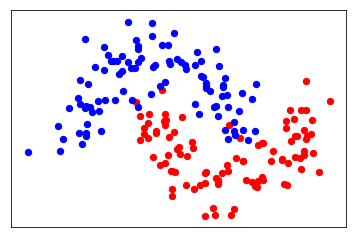

In [76]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(samples, noise=0.20)
plt.scatter(X[y==1,0], X[y==1,1], s=40, c = 'r' )
plt.scatter(X[y==0,0], X[y==0,1], s=40, c = 'b' )
plt.xticks([])
plt.yticks([])
plt.show()

In [69]:
# some random points for a dataset
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

# FF multilayer perceptron model, fixed depth, 
# specified number of nodes wide (h)
class FNN(nn.Module):
    def __init__(self, h1, h2, h3):
        super(FNN, self).__init__()
        self.main = nn.Sequential(
                    nn.Linear(2, h1),
                    nn.ReLU(),
                    nn.Linear(h1, h2),
                    nn.ReLU(),
                    nn.Linear(h2, h3),
                    nn.ReLU(),
                    nn.Linear(h3, h3),
                    nn.ReLU(),
                    nn.Linear(h3, 2),
                    )
    def forward(self, x):
        return self.main(x)
    
# FF multilayer perceptron model, fixed depth, 
# specified number of nodes wide (h)
class BNN(nn.Module):
    def __init__(self, h1, h2, h3):
        super(BNN, self).__init__()
        self.main = nn.Sequential(
                    Bayesian_fullyconnected(2, h1),
                    nn.ReLU(),
                    Bayesian_fullyconnected(h1, h2),
                    nn.ReLU(),
                    Bayesian_fullyconnected(h2, h3),
                    nn.ReLU(),
                    Bayesian_fullyconnected(h3, h3),
                    nn.ReLU(),
                    Bayesian_fullyconnected(h3, 2),
                    )
    def forward(self, x):
        return self.main(x)

In [70]:
net = FNN(h1, h2, h3)
optimizer = optim.SGD(net.parameters(), lr=0.01)
crit = nn.CrossEntropyLoss()

In [71]:
#reshape data for batches
X_batch = X_tensor.view((-1, batch_size,2))
y_batch = y_tensor.view((-1, batch_size))

In [72]:
for i in range(epochs):
    y_total = 0
    correct = 0
    for j in range(X_batch.size(0)):
        optimizer.zero_grad()
        out = net(X_batch[j].float())
        _, y_pred = torch.max(out, 1)
        y_total += y_batch[j].size(0)
        correct += (y_pred == y_batch[j]).sum().item()
        loss = crit(out, y_batch[j])
        loss.backward()
        optimizer.step()

    if i % samples == 0:
        print('epoch {}: [{}/{}] loss: {:0.5f}'.format(i, correct, y_total, loss.data[0]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


epoch 0: [96/192] loss: 0.69844
epoch 192: [177/192] loss: 0.15771
epoch 384: [185/192] loss: 0.06554
epoch 576: [185/192] loss: 0.05371
epoch 768: [186/192] loss: 0.05073
epoch 960: [186/192] loss: 0.04942
epoch 1152: [186/192] loss: 0.04833
epoch 1344: [186/192] loss: 0.04791
epoch 1536: [186/192] loss: 0.04735
epoch 1728: [186/192] loss: 0.04584
epoch 1920: [187/192] loss: 0.04496
epoch 2112: [187/192] loss: 0.04371
epoch 2304: [187/192] loss: 0.04360
epoch 2496: [187/192] loss: 0.04324
epoch 2688: [187/192] loss: 0.04228
epoch 2880: [187/192] loss: 0.04229
epoch 3072: [187/192] loss: 0.04205
epoch 3264: [187/192] loss: 0.04172
epoch 3456: [187/192] loss: 0.04139
epoch 3648: [187/192] loss: 0.04137
epoch 3840: [187/192] loss: 0.04143
epoch 4032: [187/192] loss: 0.04097
epoch 4224: [187/192] loss: 0.04102
epoch 4416: [187/192] loss: 0.04098
epoch 4608: [187/192] loss: 0.04073
epoch 4800: [187/192] loss: 0.04064
epoch 4992: [187/192] loss: 0.04017
epoch 5184: [187/192] loss: 0.04017
e

In [77]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    resolution = 0.005
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    # Predict the function value for the whole gid
    output = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float())
    _, predictions = torch.max(output.data, 1)
    Z = predictions
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contour(xx, yy, Z, cmap=plt.cm.b)
    plt.scatter(X[y==1,0], X[y==1,1], s=40, c = 'r' )
    plt.scatter(X[y==0,0], X[y==0,1], s=40, c = 'b' )
    plt.xticks([])
    plt.yticks([])
    plt.savefig('decision_boundary.pdf')

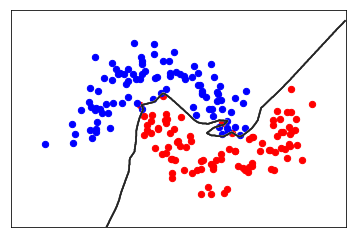

In [78]:
plot_decision_boundary(net)